In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [5]:
_ = tf.keras.utils.get_file('car.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',

                        cache_dir='./',
                        cache_subdir='masses',
                        extract=True)

In [6]:
df1 = pd.read_csv('./masses/Sound-main/meta/complete0.csv')
df2 = pd.read_csv('./masses/Sound-main/meta/complete1.csv')

merge_df = pd.concat([df1, df2], ignore_index=True)

merge_df.to_csv('./masses/Sound-main/meta/complete1.csv', index=False)

In [7]:
source_dir='./masses/Sound-main/datasets/crowd'
dest_dir='./masses/Sound-main/datasets/thunder'
base_data_path='./masses/Sound-main/datasets/all_audio_files'

In [ ]:
os.makedirs(base_data_path, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.wav'):
            shutil.move(os.path.join(root, file), dest_dir)

for file in os.listdir(dest_dir):
    if file.endswith('.wav'):
        shutil.move(os.path.join(dest_dir, file), base_data_path)

In [8]:
pd_data = pd.read_csv('./masses/Sound-main/meta/complete1.csv')
pd_data.head()

,filename,fold,target,category,risk
0,bird0.wav,1,5,bird,low
1,bird1.wav,1,5,bird,low
2,bird10.wav,1,5,bird,low
3,bird100.wav,1,5,bird,low
4,bird1000.wav,1,5,bird,low


In [9]:
my_classes = ['barrier','bicycle','bird','cat','construction','crash','crowd','dog','garbage','hrain','lrain', 'playground','rustle','siren','start','thunder','train']
map_class_to_id = {'barrier':0,'bicycle':1,'bird':2,'cat':3,'construction':4,'crash':5,'crowd':6,'dog':7,'garbage':8,'hrain':9,'lrain':10, 'playground':11,'rustle':12,'siren':13,'start':14,'thunder':15,'train':16}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,risk
0,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
1,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
2,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
3,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
4,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
5,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
6,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
7,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
8,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
9,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low


In [10]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [14]:
height=1024
depth=1

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(height, depth), name='input_emedding'),
    tf.keras.layers.Conv1D(32,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(64,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(128,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(my_classes), activation='softmax')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 511, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 254, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 126, 128)         0  

In [15]:
acc=[]
loss=[]
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            baseline=None,
                                            restore_best_weights=True)

In [16]:
for i in range(500):
    history = my_model.fit(train_ds,
                           epochs=1,
                           validation_data=val_ds,
                           callbacks=callback)
    
    
    acc.append(history.history['accuracy'])
    loss.append(history.history['loss'])
    

C:\Users\josha\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


383/383 [==============================] - 43s 112ms/step - loss: 0.1154 - accuracy: 0.9535


383/383 [==============================] - 27s 71ms/step - loss: 0.1117 - accuracy: 0.9429


383/383 [==============================] - 29s 76ms/step - loss: 0.1161 - accuracy: 0.9376


383/383 [==============================] - 27s 70ms/step - loss: 0.0944 - accuracy: 0.9566


In [19]:
#print(acc)

a=[]

for i in acc:
    a.extend(i)



In [20]:
b=[]

for i in loss:
    b.extend(i)

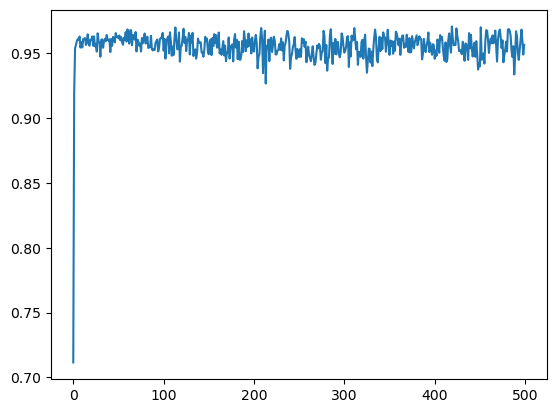

In [18]:
plt.plot(a)

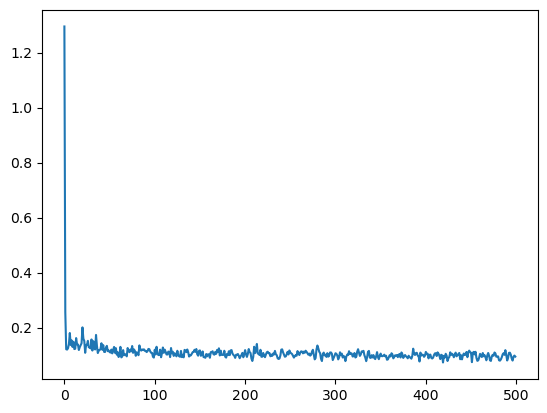

In [21]:
plt.plot(b)

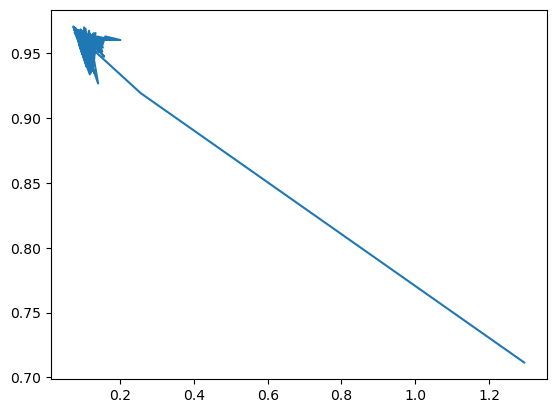

In [22]:
plt.plot(b,a)

In [27]:
with open('acc.csv', 'w', newline='') as file:
    writer=csv.writer(file)
    writer.writerows(acc)

In [28]:
with open('loss.csv', 'w', newline='') as file:
    writer=csv.writer(file)
    writer.writerows(loss)